# REINFORCE in TensorFlow

This notebook implements a basic reinforce algorithm a.k.a. policy gradient for CartPole env.

It has been deliberately written to be as simple and human-readable.


The notebook assumes that you have [openai gym](https://github.com/openai/gym) installed.

In case you're running on a server, [use xvfb](https://github.com/openai/gym#rendering-on-a-server)

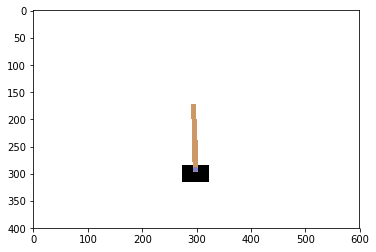

In [1]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

#gym compatibility: unwrap TimeLimit
if hasattr(env,'env'):
    env=env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import torchvision.transforms as T
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
import pixiedust

Pixiedust database opened successfully


# Building the policy network

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__. 

We'll use softmax or log-softmax where appropriate.

In [4]:
class policy_estimator():
    def __init__(self, env):
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 16), 
            nn.ReLU(), 
            nn.Linear(16, self.n_outputs),
            nn.Softmax(dim=-1))
    
    def predict(self, state):
        action_probs = self.network(torch.FloatTensor(state))
        return action_probs

In [5]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r.cumsum()[::-1].copy()
    return r

In [6]:
def generate_session(_agent, t_max=1000):
    s_0 = env.reset()
    states, actions, rewards = [], [], []
    done = False
    action_space = np.arange(env.action_space.n)

    for t in range(t_max):
        # Get actions and convert to numpy array
        action_probs = _agent.predict(s_0).detach().numpy()
        action = np.random.choice(action_space, p=action_probs)
        s_1, r, done, _ = env.step(action)

        states.append(s_0)
        rewards.append(r)
        actions.append(action)
        s_0 = s_1
           
        if done:
            break
    
    return states, actions, rewards


In [7]:
def train_on_session(_agent, _optimizer, states, actions, rewards, gamma=0.99):
    _optimizer.zero_grad()
    state_tensor = torch.FloatTensor(states)
    reward_tensor = torch.FloatTensor(discount_rewards(rewards))
    # Actions are used as indices, must be LongTensor
    action_tensor = torch.LongTensor(actions)

    # Calculate loss
    prob = _agent.predict(state_tensor)
    logprob = torch.log(
        _agent.predict(state_tensor))
    selected_logprobs = logprob[np.arange(len(action_tensor)), action_tensor]
    selected_probs = prob[np.arange(len(action_tensor)), action_tensor]
    entropy = - torch.sum(selected_probs * selected_logprobs)
    loss = -(reward_tensor * selected_logprobs).mean() - 0.001*entropy

    # Calculate gradients
    loss.backward()
    # Apply gradients
    _optimizer.step()
    
    return np.sum(rewards)

In [8]:
pe = policy_estimator(env)
optimizer = optim.Adam(pe.network.parameters(), 
                   lr=0.01)

In [9]:
for i in range(100):

    rewards = [train_on_session(pe, optimizer, *generate_session(pe))
               for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

mean reward:37.910
mean reward:54.930
mean reward:79.460
mean reward:449.520
mean reward:737.270
You Win!


### Results & video

In [14]:
def generate_session(_agent, t_max=1000):
    s_0 = env.reset()
    states, actions, rewards = [], [], []
    done = False
    action_space = np.arange(env.action_space.n)

    for t in range(t_max):
        # Get actions and convert to numpy array
        action_probs = _agent.predict(s_0).detach().numpy()
        action = np.random.choice(action_space, p=action_probs)
        s_1, r, done, _ = env.step(action)

        states.append(s_0)
        rewards.append(r)
        actions.append(action)
        s_0 = s_1
           
        if done:
            break
    
    return sum(rewards)

In [15]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session(pe) for _ in range(100)]
env.close()


In [11]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

In [16]:
from submit import submit_cartpole
submit_cartpole(generate_session, pe, "syuntoku14@gmail.com", "mygnPZCi4gI87AfJ")

Submitted to Coursera platform. See results on assignment page!


In [ ]:
# That's all, thank you for your attention!
# Not having enough? There's an actor-critic waiting for you in the honor section.
# But make sure you've seen the videos first.